# Natural Language Processing  - Jupyter Notebook
### Cecilia, Conor, Francesco 
december 2019


# Intallation of differents packages

In [ ]:
# pip install nltk 
# from the pop up window install: punkt, Averaged perceptron Tagger
# nltk.download()

In [ ]:
#pip install spacy

# Importation of packages

In [339]:
import json
import nltk
from nltk.tag import StanfordNERTagger
import os
import spacy
import textacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn import neighbors, datasets
import snowballstemmer
from nltk.corpus import stopwords
import itertools
from string import ascii_lowercase
import seaborn as sns

# Importing and Cleaning the data

In [200]:
stemmer = snowballstemmer.EnglishStemmer()
stop = stopwords.words('english')
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [285]:
tickers= pd.read_json('/Users/macbookpro/Documents/GitHub/nlp/data/word_vectors/SP500_Tickers.json', typ='series')


url2='/Users/macbookpro/Documents/GitHub/nlp/data/word_vectors/article_headers_with_dates.txt'
url3 = '/Users/macbookpro/Documents/GitHub/nlp/parsed_scrapes/main.csv'
url4 = '/Users/macbookpro/Downloads/parsed_main.csv'
header = pd.read_csv(url4,sep=",")
#del header['Unnamed: 0']
header= header.drop_duplicates()
header[(header['Date']=='31/10/19') & (header['Headline'].str.contains('goods rivals'))].loc[41725,'Headline']
header

,Date,Headline,Provider
0,20/03/17,"​ UDAY states see Rs 11,989-crore drop in inte...",Economic Times India
1,24/01/17,Income Tax India: 1 taxpayer owes 11 percent o...,Economic Times India
2,17/10/16,10 billion unhedged gap in foreign exchange de...,Economic Times India
3,19/01/17,10 percent cost reduction can add 5.5 billion ...,Economic Times India
5,11/08/15,​10 percent ethanol blending can save 1.7 bill...,Economic Times India
...,...,...,...
41770,20/10/08,Why bond prices could collapse,Money Week
41771,24/08/07,Why is the carry trade so dangerous?,Money Week
41772,16/03/09,Why the dollar will get even stronger from here,Money Week
41773,3/04/08,New biofuel laws are utter madness,Money Week


In [286]:
# remove characters and stoplist words, then generate dictionary of unique words
data = header
data['Headline'].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','',inplace=True,regex=True)
# stop.extend(['may','also','could','would', 'na', 'gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase))
# stop.extend(['may','also','could','would', 'na', 'gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase))
extensions_list = ['may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)
stop = stop.union(set(extensions_list))
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*data['Headline'].str.split(' ')))))).split(" "))
data['Headline'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in data['Headline'].str.lower().str.split(' ')]
header = data

In [287]:
ticker = tickers.to_frame('Ticker').reset_index()
ticker.columns=['Name','Ticker']
ticker

,Name,Ticker
0,AGILENT TECHNOLOGIES,A
1,AMERICAN AIRLINES,AAL
2,ADVANCE AUTO PARTS,AAP
3,APPLE,AAPL
4,ABBVIE,ABBV
...,...,...
495,XYLEM,XYL
496,YUM! BRANDS,YUM
497,ZIMMER BIOMET HOLDINGS,ZBH
498,ZIONS BANCORPORATION NA,ZION


In [266]:
list_ticker = ticker['Name'].to_list()

list_tick = ticker['Ticker'].to_list()
str3 = '|'.join(list_tick)
str1 = '|'.join(list_ticker)
str1 = str1 + str3
str1 = str1.lower()
str1

"agilent technologies|american airlines|advance auto parts|apple|abbvie|amerisourcebergen|abiomed|abbott laboratories|accenture|adobe|analog devices|archer-daniels-midland|automatic data processing|alliance data systems|autodesk|ameren|american electric power|aes|aflac|allergan|american international|apartment investment & management|assurant|arthur j gallagher &|akamai technologies|albemarle|align technology|alaska air|allstate|allegion|alexion pharmaceuticals|applied materials|amcor|advanced micro devices|ametek|affiliated managers|amgen|ameriprise financial|american tower|amazoncom|arista networks|ansys|anthem|aon|a o smith|apache|air products & chemicals|amphenol|aptiv|alexandria real estate equities|arconic|atmos energy|activision blizzard|avalonbay communities|broadcom|avery dennison|american water works|american express|autozone|boeing|bank of america|baxter international|bb&t|best buy|becton dickinson &|franklin resources|brown-forman|baker hughes a ge|biogen|bank of new york m

In [288]:
isin = pd.DataFrame(header['Headline'].str.contains(str1, regex=True))
isin

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Headline
0,True
1,True
2,True
3,True
5,True
...,...
41770,True
41771,True
41772,True
41773,True


In [289]:
index = isin[isin['Headline']==True].reset_index()['index']
#ticker.loc[index,'Ticker']
#ticker
index

0            0
1            1
2            2
3            3
4            5
         ...  
40656    41770
40657    41771
40658    41772
40659    41773
40660    41774
Name: index, Length: 40661, dtype: int64

In [290]:
index = isin[isin['Headline']==True].reset_index()['index']
index
header = header.loc[index,:].reset_index()#[['Date','Header']]

In [291]:
header

,index,Date,Headline,Provider
0,0,20/03/17,​ uday states see rs crore drop interest cost,Economic Times India
1,1,24/01/17,income tax india taxpayer owes percent indias ...,Economic Times India
2,2,17/10/16,billion unhedged gap foreign exchange deposit ...,Economic Times India
3,3,19/01/17,percent cost reduction add billion indias trad...,Economic Times India
4,5,11/08/15,​ percent ethanol blending save billion forex ...,Economic Times India
...,...,...,...,...
40656,41770,20/10/08,bond prices collapse,Money Week
40657,41771,24/08/07,carry trade dangerous,Money Week
40658,41772,16/03/09,dollar even stronger,Money Week
40659,41773,3/04/08,new biofuel laws utter madness,Money Week


# SVO and Name Entity Recognition

In [292]:
#extraction = list(textacy.extract.subject_verb_object_triples(example))


nlp = spacy.load('en_core_web_sm')

#header = 'Goldman Sachs announce purchase of Microsoft'

# Enter your username in here. I've put the paths you wrote as an attribute in the dictionary below
user = 'Francesco'

# Dictionary containing the Java paths for each user
java_paths = {
    'Conor': '/usr/lib/jvm/java-8-openjdk-amd64',
    'Francesco': '/Users/macbookpro/Downloads/jdk-13.0.1.jdk/Contents/Home/bin/java',
    'Cecilia': 'C:/Program Files/Java/jdk-13.0.1/bin/java.exe'
}
os.environ['JAVAHOME'] = java_paths[user]

st = StanfordNERTagger(
    '/Users/macbookpro/Documents/GitHub/nlp/ner/stanford-ner-2014-06-16/classifiers/english.all.3class.distsim.crf.ser.gz',
    '/Users/macbookpro/Documents/GitHub/nlp/ner/stanford-ner-2014-06-16/stanford-ner.jar',
    encoding = 'utf-8'
)
COMPANY_TYPES = ['PERSON', 'ORGANIZATION']

def get_ticker1(name, tickers):
    for key, val in tickers.items():
        if val.upper() == name.upper():
            return f'__{val}'
        if name.upper() in key.upper():
            return f'__{val}'
    return None

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
def parse_header1(header,tickers):
    '''Attempt to replace all organisations in a header with their ticker'''
    header = header.lower()
    nlp_header = nlp(header)

    tokens = list(textacy.extract.subject_verb_object_triples(nlp_header))  
    parsed_words = []
    for i in range(len(tokens)):
        ticker_0 = get_ticker1(str(tokens[i][0]), tickers)
        ticker_2 = get_ticker1(str(tokens[i][2]), tickers)  
        sub = str(tokens[i][0])
        obj = str(tokens[i][2])
        tick_sub = ''
        tick_obj = ''
        if ticker_0 is not None:
            sub = ticker_0
            tick_sub = 'sub'
        if ticker_2 is not None:
            obj = ticker_2
            tick_obj = 'obj'
        verb = str(tokens[i][1])
        tick = tick_sub + tick_obj
        if (ticker_0 != None) | (ticker_2 != None):
            parsed_words.append([sub, verb, obj, tick])
        
    return parsed_words

In [293]:
print(len(header['Headline']))

svo_df = pd.DataFrame(columns = ['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type'])

for i in range (len(header['Headline'])):
    #print(i)
    headline = header.loc[i,'Headline']
    date = header.loc[i,'Date']
    svo_headlines = parse_header1(headline,tickers)
    
    for ls in svo_headlines:
        svo_df.loc[len(svo_df)] =  [date] + ls

    
svo_df

40661


,Date,Sub,Verb,Obj,Tick_Type
0,10/08/16,__EL,default,pf payments,sub
1,22/08/17,__AMG,crore,revenue loss year,sub
2,25/02/15,recommendations,gives,__PKI,obj
3,25/02/15,recommendations,gives,__MKTX,obj
4,8/02/16,psu banks,write,__AMG,obj
...,...,...,...,...,...
4399,28/10/19,__CF,set,interestrate cut,sub
4400,29/10/19,__DRE,falling,terms,sub
4401,1/11/19,__BXP,close,village,sub
4402,31/10/19,goods rivals,fight,__TIF,obj


In [295]:
test = svo_df
svo_df['Date'] = pd.to_datetime(svo_df['Date'])

svo_df = svo_df.sort_values(by='Date')
svo_df['Sub'] = svo_df['Sub'].str.upper()
svo_df['Verb'] = svo_df['Verb'].str.upper()
svo_df['Obj'] = svo_df['Obj'].str.upper()
svo_df

print([x for x in svo_df['Verb'] if len(x.split(' ')) > 1])

#print(type(test.loc[1,'Date']))

['DONT BUY', 'DOESNT COVER', 'WONT BOOST', 'DOESNT THINK', 'DOESNT LIFT', 'BECOMING BROADBASED', 'WONT WEAKEN', 'CANT ACCEPT', 'S GOING', 'WONT TAKE', 'DOESNT WANT', 'CANT STOP', 'WONT USE', 'ISNT HURTING', 'VE DOCUMENTED', 'CANT PROTECT', 'WONT KILL', 'S GOING', 'S SOUNDING', 'RE EVADING', 'S TAKING', 'DIDNT DROP', 'CANT QUIT', 'DONT SELL', 'VE GOT', 'CANT STEP', 'VE SEEN', 'SHOULDNT CAUGHT', 'S SUING', 'CANT SAVE', 'WONT TAKE', 'NT LIKE', 'CANT TOUCH', 'CANNOT GUARANTEE', 'ARENT INVESTING', 'WONT CALL', 'CANT AFFORD', 'DOESNT UNDERSTAND', 'SHOULDNT PANIC', 'WONT INVOLVED', 'S ACCUSED', 'CANT CATCH', 'CANT CATCH', 'LL STAY', 'ARENT SLIPPING', 'ISNT ATTACKING', 'LL COST', 'LL COST', 'GOT OUTLAWYERED', 'WONT END', 'LL MARK', 'CANT RULE', 'VE SEEN', 'VE SPENT', 'VE SPENT', 'VE GONE', 'VE BOUGHT', 'DONT INCLUDE', 'DONT INCLUDE', 'WONT LEAVE', 'CANNOT FIRE', 'DOESNT KILL', 'ISNT WEDDED', 'CANNOT GUARANTEE', 'CANNOT GUARANTEE', 'CANT AFFORD', 'HASNT CHANGED', 'VE SOLD', 'LL KEEP', 'VE CHANG

# Word2Vec

In [297]:
model=word2vec.Word2Vec.load('/Users/macbookpro/Documents/GitHub/nlp/word_vectors/models/model_1')
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[[ 0.48718128 -0.60706526  0.7038868  ... -0.66943496 -0.45047
   0.37570125]
 [-0.37321308 -2.3459888  -1.933801   ...  1.1683202   3.5214005
   0.45576712]
 [ 0.18732642 -0.18230648  0.22365093 ...  0.24298605  0.38007322
  -1.3661056 ]
 ...
 [ 0.103809   -0.00444988  0.04388772 ... -0.00976374 -0.008328
   0.02769957]
 [-0.03095903  0.01710091  0.03005485 ...  0.0823025  -0.03348341
  -0.07712651]
 [-0.03180689  0.03612059  0.03987484 ...  0.00950749 -0.10370033
  -0.04906969]]


# Clustering

In [275]:
num_clusters = 100
kmeans = cluster.KMeans(n_clusters=num_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [276]:
# centroids = kmeans.cluster_centers_
# labels = kmeans.labels_

In [277]:
# n_neighbors = 5
# X = model[model.wv.vocab]
# y = labels

# h = .02  # step size in the mesh

# for weights in ['uniform', 'distance']:
#     # we create an instance of Neighbours Classifier and fit the data.
#     clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
#     clf.fit(X, y)

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [278]:
print(clf.fit(X, y))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')


In [279]:
#clf.kneighbors([X[2]],n_neighbors)

In [280]:
#model.wv['POWERING']

## Create phrases vectors
#### (Concatenating the vectors)

In [298]:
data = []

to_parse = {
    'obj': 'Sub',
    'sub': 'Obj',
    'subobj': 'Verb'
}

for i in range(len(svo_df)):
    entry = {}
    for key in ['Date', 'Sub', 'Verb','Obj', 'Tick_Type']:
        entry[key] = svo_df.loc[i, key]
    
    try:
        verb_vector = model.wv[entry['Verb']]
    except:
        verb_vector = None
        
    key_to_parse = to_parse[entry['Tick_Type']]
    
    try:
        other_vector = model.wv[entry[key_to_parse]]
    except:
        other_vector = None
        
    if verb_vector is not None and other_vector is not None:
        final_vector = np.concatenate((verb_vector, other_vector))
        entry['final_vector'] = final_vector
    else:
        entry['final_vector'] = None
    
    data.append(entry)
    
# for i, verb in enumerate(svo_df['Verb']):
# #     verb = svo_df.loc[i,'Verb']
#     svo_df.loc[i,'Verb_vector'] = model.wv[verb]

# Determine which tickers are the most quoted by articles

4404


,tickers,counts
16,__CBOE,171
7,__CF,110
38,__ALXN,84
8,__HBAN,80
25,__STI,64


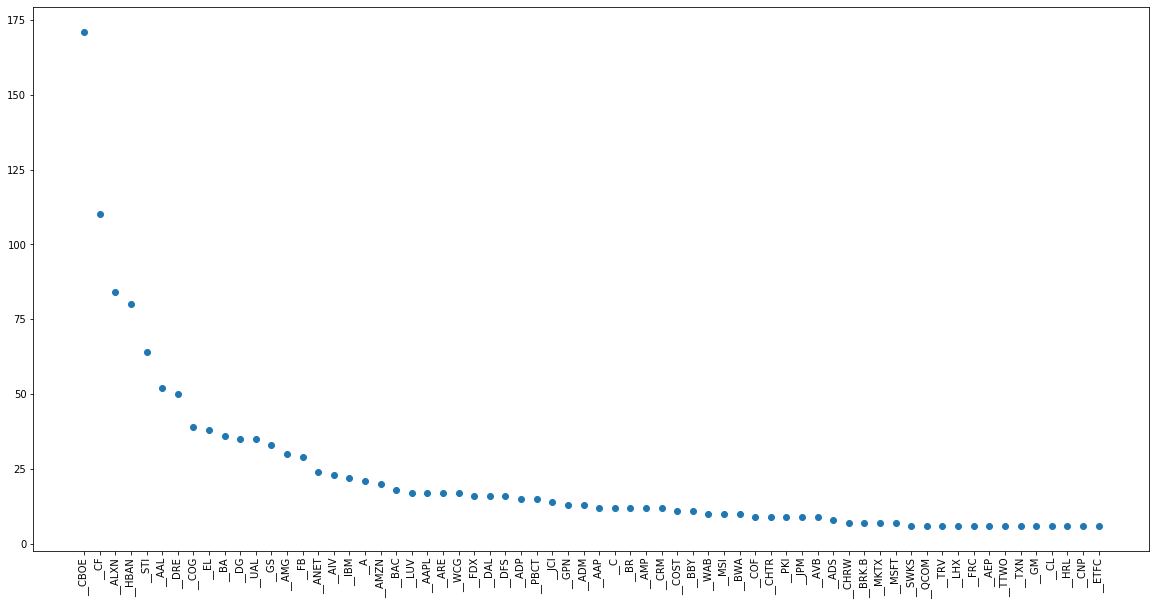

In [392]:
print(len(data))
tickers_list = []
for x in data:
    if (x['Tick_Type'] == 'sub')&(x['final_vector'] is not None):
        tickers_list.append(x['Sub'])
    elif (x['Tick_Type'] == 'obj')&(x['final_vector'] is not None):
        tickers_list.append(x['Obj'])

tickers_list

from collections import Counter
counts = dict(Counter(tickers_list))

to_parse = {'tickers': [], 'counts': []}
for ticker, count in counts.items():
    to_parse['tickers'].append(ticker)
    to_parse['counts'].append(count)
    

ticker_counts = pd.DataFrame(to_parse)
ticker_counts = ticker_counts.sort_values(by = 'counts', ascending = False)
ticker_counts1 = ticker_counts[ticker_counts['counts']>5]
plt.figure(figsize = [20,10])
plt.scatter(ticker_counts1['tickers'], ticker_counts1['counts'])
plt.xticks(rotation = 'vertical')
#print(json.dumps(counts, indent = 2))
ticker_counts.head()
# plt.figure(figsize=(10,5))
# chart = sns.countplot(
#     data = ticker_counts,
#     x='tickers',
#     y = 'counts',
#     palette='Set1'
# )
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

# Clustering phrases vectors

In [303]:
vocab = [x['final_vector'] for x in data if x['final_vector'] is not None]
num_clusters = 100
kmeans = cluster.KMeans(n_clusters=num_clusters)
kmeans.fit(vocab)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Mapping

In [304]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [306]:
n_neighbors = 5
y = labels

h = .02  # step size in the mesh

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
    clf.fit(vocab, y)

In [308]:
print(clf.fit(vocab, y))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')


In [309]:
clf.kneighbors([vocab[2]],n_neighbors)

(array([[ 0.        , 12.86360301, 13.11185799, 13.33909105, 13.37326131]]),
 array([[  2, 392, 861, 381, 509]]))

# Returns study

In [414]:
returnsdf = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/returns/returnsSP500.csv')
returnsdf

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
0,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,-0.076389,NaN,NaN,-0.084310,NaN,-0.068273,-0.023973,-0.028571,NaN,...,0.023026,-0.022727,-0.019154,0.000000,-0.046512,NaN,-0.020100,NaN,-0.048423,NaN
2,2000-01-05,-0.062030,NaN,NaN,0.014634,NaN,0.077586,0.010526,-0.001838,NaN,...,0.038585,-0.021888,0.054516,0.017287,0.051490,NaN,0.005128,NaN,-0.001183,NaN
3,2000-01-06,-0.038076,NaN,NaN,-0.086538,NaN,0.076000,0.001736,0.034991,NaN,...,-0.009288,-0.086713,0.051698,0.001307,-0.020619,NaN,-0.008503,NaN,0.014218,NaN
4,2000-01-07,0.083333,NaN,NaN,0.047368,NaN,0.130112,-0.005199,0.010676,NaN,...,0.000000,0.113323,-0.002935,-0.002611,0.023684,NaN,-0.022298,NaN,0.002336,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,2019-11-27,0.001606,-0.003442,0.010758,0.013432,0.006954,0.007513,0.013024,0.000000,0.001642,...,0.006211,0.023126,-0.000582,0.001227,0.013055,0.005962,0.008922,0.011735,0.008256,-0.002133
5009,2019-11-29,-0.003823,-0.007254,-0.010707,-0.002203,-0.006793,-0.006779,-0.003100,0.000351,-0.000447,...,-0.001137,-0.006106,-0.008297,-0.009981,0.003351,-0.001288,0.000298,-0.008734,-0.005792,-0.009126
5010,2019-12-02,-0.005200,-0.022965,-0.003374,-0.011562,-0.007979,-0.000910,-0.020186,-0.011001,-0.007805,...,-0.004716,-0.027053,0.004257,0.002830,-0.011045,-0.012385,-0.001093,-0.005644,-0.005625,-0.005061
5011,2019-12-03,-0.003111,-0.028134,-0.025168,-0.017830,-0.012410,-0.004554,-0.005567,-0.001775,-0.004209,...,0.004248,-0.017946,-0.007892,0.007584,-0.006494,-0.013194,-0.011038,-0.007338,-0.018788,0.005171


In [423]:
print(len(returnsdf.columns))
print(returnsdf.columns[22:100])

501
Index(['AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE',
       'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT',
       'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH',
       'APTV', 'ARE', 'ARNC', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK',
       'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBT', 'BBY', 'BDX', 'BEN', 'BF-B',
       'BHGE', 'BIIB', 'BK', 'BKNG', 'BLK', 'BLL', 'BMY', 'BR', 'BRK-B', 'BSX',
       'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CBS',
       'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CELG', 'CERN', 'CF', 'CFG', 'CHD',
       'CHRW', 'CHTR'],
      dtype='object')


In [477]:
params = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/SP500_parameters.csv')
params['Ticker_b']=params['Ticker']
params['Ticker']='__'+params['Ticker']
params.loc[50:100,'Ticker_b']

50      ARNC
51       ATO
52      ATVI
53       AVB
54      AVGO
55       AVY
56       AWK
57       AXP
58       AZO
59        BA
60       BAC
61       BAX
62       BBT
63       BBY
64       BDX
65       BEN
66      BF.B
67      BIIB
68        BK
69      BKNG
70       BLK
71       BLL
72       BMY
73        BR
74     BRK.B
75       BSX
76       BWA
77       BXP
78         C
79       CAG
80       CAH
81       CAT
82        CB
83      CBOE
84      CBRE
85       CBS
86       CCI
87       CCL
88      CDNS
89       CDW
90        CE
91      CERN
92        CF
93       CFG
94       CHD
95      CHRW
96      CHTR
97        CI
98      CINF
99        CL
100      CLX
Name: Ticker_b, dtype: object

In [394]:
ticker_counts.columns=['Ticker','count']
ticker_counts = ticker_counts.merge(params[['Ticker','GICS']],on = 'Ticker')

,Ticker,count,GICS
0,__CBOE,171,Financials
1,__CF,110,Materials
2,__ALXN,84,Health Care
3,__HBAN,80,Financials
4,__STI,64,Financials
...,...,...,...
234,__PHM,1,Consumer Discretionary
235,__ADBE,1,Information Technology
236,__AMAT,1,Information Technology
237,__RF,1,Financials


## Which industries are the most tackled by headlines 
##### in order to have enough data to study

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], <a list of 11 Text xticklabel objects>)

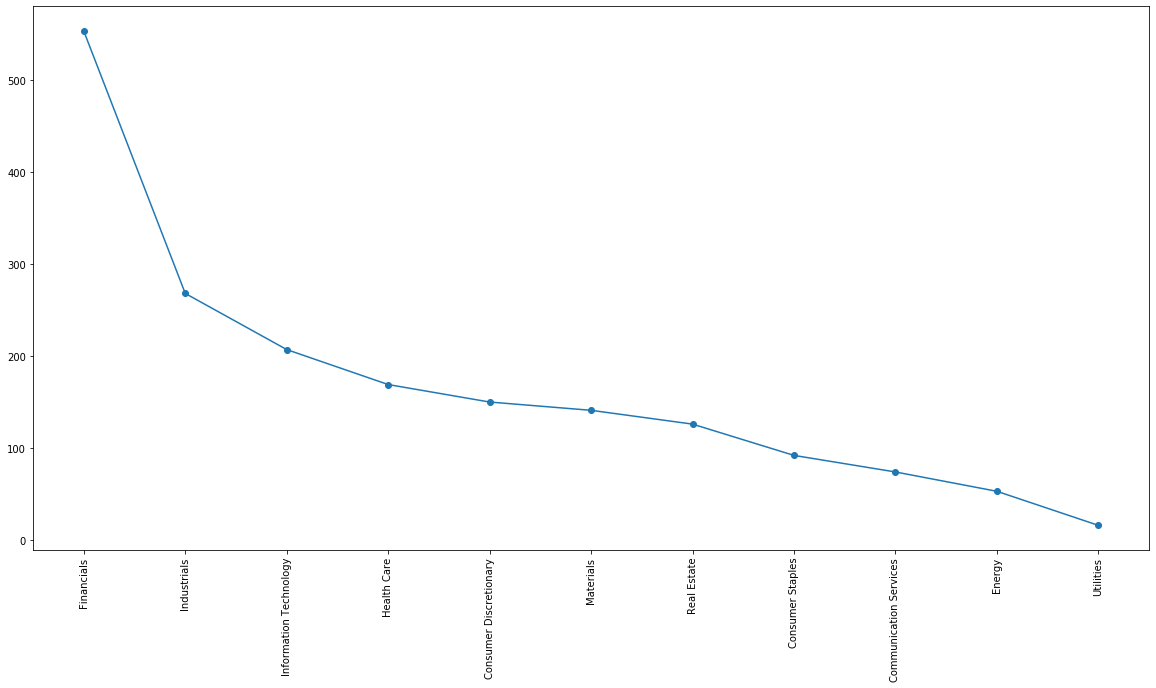

In [410]:
GICS_count = ticker_counts.groupby(['GICS']).agg(['sum'])
GICS_count =GICS_count.sort_values(by = ('count','sum'),ascending=False)
# GICS_count
# plt.plot(GICS_count[('count','sum')])

plt.figure(figsize = [20,10])
plt.plot(GICS_count[('count','sum')], marker = 'o')

# plt.bar(GICS_count['count'], GICS_count['sum'])

plt.xticks(rotation = 'vertical')

# GICS_count = GICS_count.sort_values(by = 'count', ascending = False)

In [442]:
industries = ['Financials', 'Industrials', 'Information Tecnology']
dataframe_industry_dict = {}
for industry in industries:
    industry_ticker = params.loc[params['GICS']==industry,'Ticker']
    industry_ticker=industry_ticker.str.replace('__','')
    industry_ticker=industry_ticker.str.replace('.','-')
    
    date = pd.Series(['Date'])
    df_industry = returnsdf[industry_ticker.append(date)]
#     dataframe_industry_dict[industry] = df_industry
    
    df_industry['market_exp']=df_industry[industry_ticker].mean(axis=1)
    df_industry = df_industry.iloc[1:,:]#.dropna()
    cols = df_industry.columns
    cols = cols[-2:].append(cols[:(len(cols)-2)])
    df_industry=df_industry[cols]
    dataframe_industry_dict[industry] = df_industry
#print(len(healthy_ticker))

#print(len(df_health.columns))
# df_health
dataframe_industry_dict['Financials']


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Date,market_exp,AFL,AIG,AIZ,AJG,ALL,AMG,AMP,AON,...,STI,STT,SYF,TROW,TRV,UNM,USB,WFC,WLTW,ZION
1,2000-01-04,-0.035024,-0.026536,-0.051112,NaN,-0.045187,-0.031915,-0.079932,NaN,-0.022436,...,-0.036715,-0.055556,NaN,-0.030249,-0.013258,-0.018443,-0.036474,-0.049521,NaN,-0.048423
2,2000-01-05,-0.006698,-0.005739,0.002376,NaN,0.004115,0.043956,-0.024030,NaN,0.029508,...,-0.011033,0.018027,NaN,-0.001835,-0.007678,-0.033403,-0.022082,-0.010084,NaN,-0.001183
3,2000-01-06,0.023833,0.020202,0.030504,NaN,-0.001793,-0.005263,0.030303,NaN,0.035032,...,0.013185,0.041938,NaN,0.029412,0.019342,0.021598,0.077419,0.044143,NaN,0.014218
4,2000-01-07,0.021625,0.019802,0.074847,NaN,0.038748,0.037037,0.023897,NaN,0.052308,...,-0.002002,0.035778,NaN,-0.007143,0.039848,0.014799,0.038922,0.017886,NaN,0.002336
5,2000-01-10,-0.013937,-0.059639,-0.017694,NaN,-0.036561,-0.022959,0.025135,NaN,-0.295322,...,-0.045135,-0.006045,NaN,0.010791,-0.018248,-0.004167,-0.005764,-0.031949,NaN,-0.018065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,2019-11-27,0.004481,0.001644,-0.005266,-0.001872,0.008322,-0.005328,0.003503,0.014719,0.005117,...,0.008506,0.013999,-0.000267,0.007164,0.001171,0.016921,0.004506,0.009849,0.007853,0.008256
5009,2019-11-29,-0.002879,0.000365,-0.004349,-0.003226,-0.000322,-0.005981,-0.006748,0.002938,-0.003231,...,-0.004217,-0.003053,0.000803,-0.001213,-0.000877,0.002936,-0.002658,0.002208,0.000458,-0.005792
5010,2019-12-02,-0.008494,-0.039387,-0.018990,-0.008730,-0.011150,-0.001886,-0.021905,-0.007994,-0.009872,...,-0.005929,0.003728,-0.007217,-0.010521,-0.010679,-0.008458,-0.004498,-0.015424,-0.006211,-0.005625
5011,2019-12-03,-0.014515,-0.018033,-0.009485,-0.024372,-0.009541,-0.015296,-0.020599,-0.015871,-0.007986,...,-0.022011,-0.023481,-0.008616,-0.012024,-0.004732,-0.050525,-0.013889,-0.019396,-0.013831,-0.018788


# LIBOR 3M importation

In [443]:
libor = pd.read_excel('/Users/macbookpro/Documents/GitHub/nlp/data/LIBOR_3M.xlsx')
libor['LIBOR 3M'] = libor['LIBOR 3M']/100
libor['Date'] = pd.to_datetime(libor['Date'])
libor

,Date,LIBOR 3M
0,2010-01-01,0.002506
1,2010-01-04,0.002544
2,2010-01-05,0.002525
3,2010-01-06,0.002500
4,2010-01-07,0.002494
...,...,...
2481,2019-07-08,0.023377
2482,2019-07-09,0.023407
2483,2019-07-10,0.023395
2484,2019-07-11,0.023034


In [444]:
for industry in industries:
    test = dataframe_industry_dict[industry]
    test['Date']= pd.to_datetime(test['Date'])
    test = test.merge(libor,on='Date')
    
    cols = test.columns
    cols = cols[-1:].append(cols[:(len(cols)-1)])
    test=test[cols]
    
    dataframe_industry_dict[industry] = test
dataframe_industry_dict['Financials']

,LIBOR 3M,Date,market_exp,AFL,AIG,AIZ,AJG,ALL,AMG,AMP,...,STI,STT,SYF,TROW,TRV,UNM,USB,WFC,WLTW,ZION
0,0.002544,2010-01-04,0.018151,0.028541,-0.003002,0.023066,-0.007996,0.012317,0.022717,0.027306,...,0.007393,0.021130,NaN,0.021596,-0.001003,0.021516,0.016437,0.012227,0.014784,0.038971
1,0.002525,2010-01-05,0.010028,0.029010,-0.018735,0.029841,-0.005374,0.016442,0.007985,0.023320,...,0.013699,0.002024,NaN,0.011213,-0.023690,0.014544,0.025350,0.027452,-0.002241,0.035259
2,0.002500,2010-01-06,0.003747,0.008784,-0.006478,-0.002898,0.000450,0.000324,0.019588,0.013967,...,0.027992,-0.016611,NaN,-0.015633,-0.014189,0.008898,0.010656,0.001425,0.016099,0.086957
3,0.002494,2010-01-07,0.019587,0.010733,-0.019218,0.012270,-0.006301,0.005175,-0.004520,0.007491,...,0.059155,0.018032,NaN,-0.000739,0.014393,0.022048,0.019401,0.036286,-0.002948,0.112000
4,0.002512,2010-01-08,0.001277,-0.010018,0.026592,0.000638,0.002717,0.004183,-0.009224,0.003598,...,0.019947,0.020404,NaN,-0.003881,-0.001439,-0.013423,0.001655,-0.009269,-0.001109,-0.016187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,0.023377,2019-07-08,-0.008997,-0.002816,0.006409,0.003269,-0.002428,-0.001053,-0.016804,-0.007860,...,-0.006723,-0.030634,0.002527,-0.013222,-0.001882,-0.006069,-0.010805,-0.005024,-0.005974,-0.019260
2393,0.023407,2019-07-09,0.004561,-0.002118,0.010189,0.001810,0.004316,0.002683,0.010054,0.008460,...,0.013222,0.000182,0.001681,0.007893,-0.002276,0.004653,0.004520,0.006312,0.002979,0.013460
2394,0.023395,2019-07-10,-0.005527,-0.000354,0.003782,-0.006053,0.001102,-0.003822,0.001548,-0.012517,...,-0.005437,-0.011803,-0.006711,-0.003369,-0.000782,-0.048625,-0.003000,-0.014217,0.001844,-0.014152
2395,0.023034,2019-07-11,0.006526,-0.002654,-0.004486,0.000818,0.005723,-0.010646,0.005079,0.014159,...,0.010622,0.011393,0.003378,-0.001188,-0.005870,-0.006693,0.005453,-0.000212,0.003527,0.012368


# Computation of abnormal returns

In [480]:
abret_dict = {}
for industry in industries:
    df_returns = dataframe_industry_dict[industry]
    df_industry_capm=pd.DataFrame(df_returns['Date'])
#What do we choose for rf ?
#LIBOR overnight
    risk_free_rate = df_returns['LIBOR 3M']
    market = df_returns['market_exp']
    #print(df_returns.columns)
    for col in df_returns.columns[3:] :
        col = col.replace('-','.')
        #print(col)
        beta = params.loc[params['Ticker_b']==col]['Beta'].values[0]
        #print(beta)
        #print(type(beta))
    #print(beta)
        df_industry_capm[col] = risk_free_rate + beta*(market-risk_free_rate)
    abret_dict[industry] = df_industry_capm
    

abret_dict['Financials']

,Date,AFL,AIG,AIZ,AJG,ALL,AMG,AMP,AON,AXP,...,STI,STT,SYF,TROW,TRV,UNM,USB,WFC,WLTW,ZION
0,2010-01-04,0.013758,0.017380,0.014501,0.014780,0.013640,0.023074,0.025357,0.015356,0.019327,...,0.017581,0.018942,0.018374,0.021629,0.013088,0.022462,0.015909,0.016143,0.014635,0.018923
1,2010-01-05,0.007916,0.009658,0.008273,0.008408,0.007860,0.012395,0.013493,0.008685,0.010593,...,0.009754,0.010408,0.010136,0.011700,0.007594,0.012101,0.008950,0.009063,0.008338,0.010399
2,2010-01-06,0.003396,0.003686,0.003456,0.003478,0.003387,0.004141,0.004323,0.003524,0.003841,...,0.003702,0.003810,0.003765,0.004025,0.003343,0.004092,0.003568,0.003587,0.003466,0.003809
3,2010-01-07,0.014775,0.018742,0.015589,0.015895,0.014646,0.024978,0.027479,0.016525,0.020874,...,0.018962,0.020452,0.019831,0.023395,0.014042,0.024307,0.017131,0.017387,0.015735,0.020432
4,2010-01-08,0.001625,0.001338,0.001566,0.001544,0.001634,0.000888,0.000707,0.001498,0.001184,...,0.001322,0.001215,0.001260,0.001002,0.001678,0.000936,0.001455,0.001436,0.001556,0.001216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,2019-07-08,0.000117,-0.007397,-0.001425,-0.002004,0.000360,-0.019208,-0.023943,-0.003198,-0.011434,...,-0.007813,-0.010636,-0.009458,-0.016209,0.001506,-0.017937,-0.004345,-0.004830,-0.001702,-0.010597
2393,2019-07-09,0.009866,0.005492,0.008969,0.008631,0.010008,-0.001384,-0.004141,0.007936,0.003142,...,0.005249,0.003606,0.004292,0.000362,0.010675,-0.000644,0.007269,0.006986,0.008807,0.003629
2394,2019-07-10,0.002615,-0.004098,0.001237,0.000719,0.002832,-0.014650,-0.018881,-0.000347,-0.007705,...,-0.004470,-0.006992,-0.005940,-0.011971,0.003855,-0.013515,-0.001372,-0.001805,0.000990,-0.006957
2395,2019-07-11,0.011173,0.007341,0.010387,0.010091,0.011297,0.001319,-0.001096,0.009482,0.005283,...,0.007129,0.005690,0.006290,0.002848,0.011881,0.001967,0.008898,0.008650,0.010245,0.005709
